Zadanie polega na stworzeniu modelu rekurencyjnego, który będzie przewidywał kompozytora danego utworu muzyki klasycznej w oparciu o jego zapis w formie sekwencji akordów. Akordy znormalizowane zostały do klucza C-dur lub a-moll, w zależności od skali utworu (durowa/molowa).
Dane przygotowane są w postaci pickle (https://docs.python.org/3/library/pickle.html), w których znajduje się lista krotek z sekwencjami i odpowiadającymi im klasami (kompozytorami), odpowiednio: {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}. Dane treningowe znajdują się w pliku train.pkl. W pliku test_no_target.pkl znajdują się testowe sekwencje, dla których predykcje mają Państwo przewidzieć.

Uwaga, utwory mogą mieć różne długości. Do stworzenia batchy dla przykładów różnej długości proszę wykorzystać omówiony na zajęciach padding i trenować z wykorzystaniem spaddowanych tensorów lub spakowanych sekwencji (PackedSequence).

Bardzo proszę, żeby zwrócili Państwo archiwum zip, zgodnie z instrukcjami:
- Archiwum powinno być nazwane {poniedzialek/piatek}_nazwisko1_nazwisko2.zip (lub nazwa drużyny), bez nawiasów klamrowych przy dniu tygodnia
- W archiwum proszę bez zbędnych podfolderów umieścić pliki ze swoim kodem i testowe predykcje nazwane {poniedzialek/piatek}_nazwisko1_nazwisko2.csv (lub nazwa drużyny), bez nawiasów klamrowych przy dniu tygodnia
- Testowe predykcje powinny mieć kolejność zgodną z kolejnością sekwencji w picklu. Plik csv. nie powinien mieć nagłówka ani indeksów.

Proszę zwracać uwagę na prawidłowe nazewnictwo oraz odpowiedni format zwracanych plików. Niedostosowanie się do wytycznych może spowodować nieuwzględnienie Państwa w rankingu i utratę punktów za osiągnięty wynik!

In [25]:
# !pip install GPUtil
#
# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda
#
# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()
#
#     torch.cuda.empty_cache()
#
#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)
#
#     print("GPU Usage after emptying the cache")
#     gpu_usage()
#
# free_gpu_cache()
#
# import sys
# torch.cuda.empty_cache()
# sys.modules[__name__].__dict__.clear()
# !nvidia-smi

In [26]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [27]:
device = torch.device("cuda")
device

device(type='cuda')

Prepare dataset


In [28]:
import pickle

In [37]:
file = open('train.pkl', 'rb')
train = pickle.load(file)
file.close()

test_file = open('test_no_target.pkl', 'rb')
test_no_target = pickle.load(test_file)
test_file.close()

In [30]:
train

[(array([ -1.,  -1.,  -1., ...,  78.,  40., 144.]), 0),
 (array([ -1.,  -1., 144., ...,  32.,  -1.,  -1.]), 0),
 (array([ 66., 100., 148., 148., 146.,  64., 146., 148.,  82.,   0.,  82.,
         100.,  34., 132., 180.,  65.,  80.,  81., 131.,  52.,  34.,  52.,
          64.,  52.,   3.,  66., 147.,  20.,   4., 132., 132., 100., 111.,
          74., 110.,  60.,  92.,  65., 100., 189.,  44.,   8.,   5.,  76.,
          31., 159.,   5., 124.,   4.,  12.,  51., 157.,  57.,  31., 183.,
          57.,  65.,  92.,  69., 124., 122.,  79., 110.,  76.,  12.,  12.,
          12.,  12.,   8., 159.,  12., 156., 100., 111.,  52., 121.,  36.,
          47.,  41.,  41.,   8., 172.,  38.,  12.,  78.,  12.,  88.,  47.,
         119.,  20.,  47.,  12., 159.,  20.,  20.,  76.,  60., 110., 132.,
         185., 120.,  45., 110., 110.,  72., 124., 178.,  73.,   8.,  78.,
          12.,  42., 173.,  12., 150.,  84.,  66., 152.,  69.,   8.,  41.,
         159.,   5.,  78.,  44., 180.,  71.,  92., 152.,   6., 

In [31]:
test_no_target

[array([  0.,   0.,   0.,   0.,  88.,  88.,  88.,  88.,  69., 145., 145.,
        145.,   5.,   5.,   5.,   5.,  92.,  88.,  88.,  80.,  45.,  39.,
        190., 190., 124., 112., 112., 112.,  77.,  36.,  36.,  36.,  20.,
         20.,  13., 158., 127.,  55.,  55., 113., 127., 151.,  22., 116.,
        144., 144.,  34.,  68.,  33.,  33.,  33.,  41.,  41.,  47.,  47.,
        180.,  12., 119.,  37., 100., 112., 112.,   2.,  36.,   0.,   0.,
          0.,   0.,  88.,  88., 120., 120.,  12.,   5.,  13.,  13.,  92.,
        149.,  32.,   4.,  12.,  37.,  12., 159.,  13.,   6., 124.,  37.,
        124.,  37.,  37.,   8.,   8., 119.,  78.,  73.,  12.,   0.,   0.,
          0.,  88.,  88.,  88.,  88.,  69., 145., 145., 145.,   5.,   5.,
          5.,   5.,  92.,  88.,  88.,  80.,  45.,  39., 190., 190., 124.,
        112., 112., 112.,  77.,  36.,  36.,  36.,  20.,  20.,  13., 158.,
        127.,  55.,  55., 113., 127., 151.,  22., 116., 144., 144.,  34.,
         68.,  33.,  33.,  33.,  41., 

(30, 5322)


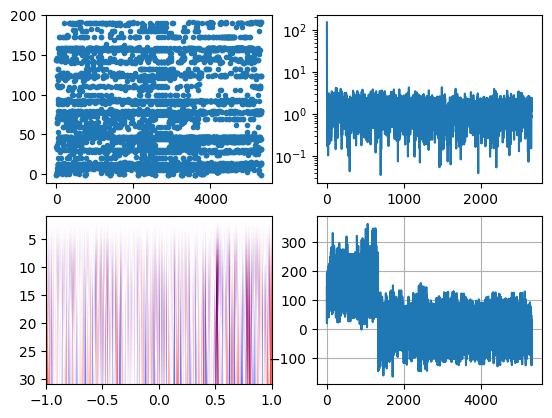

In [32]:
import pywt
from scipy.fft import fft, fftfreq
from scipy import signal

def flatten_list(l):
    return [item for sublist in l for item in sublist]
#choosen_sample = np.delete(train[200][0],[0])
choosen_sample =train[1][0] # orginal signal
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
N = len(choosen_sample)
T = 1.0 / len(choosen_sample)
ax1.plot(choosen_sample,'.')

yfreq = fft(choosen_sample) # Fourier transform
xfreq = fftfreq(N, T)[:N//2]
ax2.semilogy(xfreq, 2.0/N * np.abs(yfreq[0:N//2]))

widths = np.arange(1, 31)
wavelet = signal.ricker # only option unfortunately
#cwtmatr = signal.cwt(choosen_sample , wavelet, widths) # Continuous Wavelet Transform

cwtmatr, freqs = pywt.cwt(choosen_sample, widths, 'mexh') # Continuous Wavelet Transform # 'gaus1'
print(cwtmatr.shape)

coeffArray = pywt.wavedec(choosen_sample,'db1',level=2)  # Multilevel discrete Wavelet transform
#print(coeffArray)
ax3.imshow(cwtmatr, extent=[-1, 1, 31, 1], cmap='seismic', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

dwt_coeffs = flatten_list(coeffArray)

ax4.plot(dwt_coeffs)

plt.grid()
plt.show()

In [33]:
# train_x0 = []
# train_x1 = []
# train_x2 = []
# train_x3 = []
# train_x4 = []
#
# for i in range(0,len(train[:])):
#     if train[i][1] == 0:
#         train_x0.append(train[i][0])
#     elif train[i][1] == 1:
#         train_x1.append(train[i][0])
#     elif train[i][1] == 2:
#         train_x2.append(train[i][0])
#     elif train[i][1] == 3:
#         train_x3.append(train[i][0])
#     else:
#         train_x4.append(train[i][0])
#
#
#
# plt.hist(train_x0[:],density=True,lw=3,fc=(0, 1, 0, 0.2))
# plt.show()
# plt.hist(train_x1[:],density=True,lw=3,fc=(0, 1, 0, 0.2))
# plt.show()
# plt.hist(train_x2[:],density=True,lw=3,fc=(1, 0, 0, 0.2))
# plt.show()
# plt.hist(train_x3[:],density=True,lw=3,fc=(1, 1, 0, 0.2))
# plt.show()
# plt.hist(train_x4[:],density=True,lw=3,fc=(1, 0, 1, 0.2))
# plt.show()

In [10]:
from torch import nn
from torch.nn.utils.rnn import pad_sequence

In [49]:
import random
from scipy import signal
from random import sample
import itertools
def swapNresample(list_set, std):
    sampled_list = sample(list_set, 1) # one sample
    compositor = sampled_list[0][1] # target
    sampled_list = sampled_list[0][0]
    l = int(len(sampled_list)/4)

    #print(sampled_list )
    r1_a = int(round(random.uniform(5,int(l/2)-1),0))
    r1_b = int(round(random.uniform(int(l/2),l-5),0))

    if r1_a > r1_b:
        r1_c = r1_a
        r1_a = r1_b
        r1_b = r1_c
        l_off = r1_b
    else:
        l_off = r1_a

    offset = int(round(random.uniform(2,l_off-1),0))
    r2_a = r1_a - offset
    r2_b = r1_b - offset

    if r2_a <= -1 or r2_b <= -1 or r1_a <= -1 or r1_b <= -1:
        off2 = int(round(random.uniform(20,50),0))
        r2_a +=off2
        r2_b +=off2
        r1_a +=off2
        r1_b +=off2
    #print(r1_a,r1_b,r2_a,r2_b)

    augument_select = int(random.randint(0,3))
    if augument_select == 0:
        # SWITCHING BLOCK OF CLASSICAL MUSIC BY RANGE
        sampled_list[r2_a:r2_b], sampled_list[r1_a:r1_b] = sampled_list[r1_a:r1_b], sampled_list[r2_a:r2_b]
        # CUT SONG IN RANGE
    elif augument_select == 1:
        sampled_list[r1_a:r1_b] = 0
    elif augument_select == 2:
        sampled_list[r2_a:r2_b] = 0
    else:
        # ## ADDING NOISE - probably bad idea in this type of data
        sl = signal.resample(sampled_list,len(sampled_list))
        for i in range(0,len(sl)):
           sampled_list[i] = int(round(random.uniform(sl[i]-sl[i]*std, sl[i]+sl[i]*std),0))
    return sampled_list,compositor #touple output


std = 5
#print(f)
train_c0 = []
train_c1 = []
train_c2 = []
train_c3 = []
train_c4 = []

for i in range(0,len(train[:])):
    if train[i][1] == 0:
        train_c0.append(train[i])
    elif train[i][1] == 1:
        train_c1.append(train[i])

    elif train[i][1] == 2:
        train_c2.append(train[i])
    elif train[i][1] == 3:
        train_c3.append(train[i])
    else:
        train_c4.append(train[i])

l0 = len(train_c0)
l1 = len(train_c1)
l2 = len(train_c2)
l3 = len(train_c3)
l4 = len(train_c4)

#l_max = max(l0,l1,l2,l3,l4)
#print(l0,l1,l2,l3,l4)
l_max = 2000
#
for i in range(l0,l_max):
    train_c0.append(swapNresample(train_c0,std))

for i in range(l1,l_max):
    train_c1.append(swapNresample(train_c1,std))

for i in range(l2,l_max):
    train_c2.append(swapNresample(train_c2,std))

for i in range(l3,l_max):
    train_c3.append(swapNresample(train_c3,std))

for i in range(l4,l_max):
    train_c4.append(swapNresample(train_c4,std))

l0 = len(train_c0)
l1 = len(train_c1)
l2 = len(train_c2)
l3 = len(train_c3)
l4 = len(train_c4)
#print(l0,l1,l2,l3,l4)


train = list(itertools.chain(train_c0, train_c1, train_c2,train_c3,train_c4))
print(len(train))

10000


In [50]:
# Find the longest piece in train data
max_len = 0
for train_el in train:
    if max_len < len(train_el[0]):
        max_len = len(train_el[0])

max_len

6308

In [51]:
# Find the longest piece in test data
max_len_test = 0
for test_el in test_no_target:
    if max_len_test < len(test_el):
        max_len_test = len(test_el)

max_len_test

8966

In [52]:
if(max_len_test > max_len):
      max_len = max_len_test

In [53]:
# DO THE PADDING TO EVERY PIECE
for i in range(len(train)):                                                         
    zeros_padding = np.array([0 for z in range (max_len - len(train[i][0]))])       
    train[i] = list(train[i])
    train[i][0] = np.append(train[i][0], zeros_padding)     
    train[i] = tuple(train[i])

In [54]:
for i in range(len(test_no_target)):
    zeros_padding = np.array([0 for z in range (max_len - len(test_no_target[i]))])
    test_no_target[i] = list(test_no_target[i])
    test_no_target[i] = np.append(test_no_target[i], zeros_padding)
    test_no_target[i] = tuple(test_no_target[i])

Checking if any class overweights others

In [55]:
count = [0 for i in range(5)]
for train_el in train:
    for i in range(5):
        if train_el[1] == i:
            count[i] = count[i] + 1
count

[2000, 2000, 2000, 2000, 2000]

(30, 8966)
(8966,)


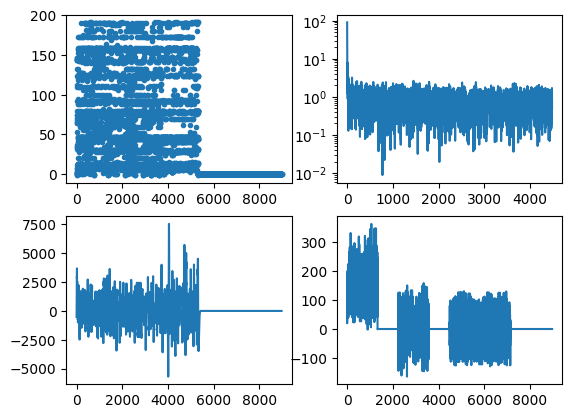

In [96]:
import pywt
from scipy.fft import fft, fftfreq
from scipy import signal

def flatten_list(l):
    return [item for sublist in l for item in sublist]
#choosen_sample = np.delete(train[200][0],[0])
choosen_sample =train[1][0] # orginal signal
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
N = len(choosen_sample)
T = 1.0 / len(choosen_sample)
ax1.plot(choosen_sample,'.')

yfreq = fft(choosen_sample) # Fourier transform
xfreq = fftfreq(N, T)[:N//2]
ax2.semilogy(xfreq, 2.0/N * np.abs(yfreq[0:N//2]))

widths = np.arange(1, 31)
wavelet = signal.ricker # only option unfortunately
#cwtmatr = signal.cwt(choosen_sample , wavelet, widths) # Continuous Wavelet Transform

cwtmatr, freqs = pywt.cwt(choosen_sample, widths, 'mexh') # Continuous Wavelet Transform # 'gaus1'
print(cwtmatr.shape)

coeffArray = pywt.wavedec(choosen_sample,'db1',level=2)  # Multilevel discrete Wavelet transform
#print(coeffArray)
# ax3.imshow(cwtmatr, extent=[-1, 1, 31, 1], cmap='seismic', aspect='auto',
#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

cwtmatr_sum = cwtmatr[0][:]
for i in range(1,len(cwtmatr)-1):
    cwtmatr_sum += cwtmatr[i][:]

ax3.plot(cwtmatr_sum)

print(cwtmatr_sum.shape)
dwt_coeffs = flatten_list(coeffArray)

ax4.plot(dwt_coeffs)


plt.show()

In [57]:
fft_train = []
fft_test_no_target = []
cwt_train = []
cwt_test_no_target = []
dwt_train = []
dwt_test_no_target = []
cwtwavelet = 'mexh'
dwtwavelet = 'db1'
w2_wavelet = 31
level = 2
widths = np.arange(1, w2_wavelet) # can be changed to optimize learning
for i in range(0,len(train)):
    choosen_sample =train[i][0]
    yfreq = fft(choosen_sample)
    N = 20000
    T = 1.0 / len(choosen_sample)
    fft_train.append(2.0/N * np.abs(yfreq[0:N//2]))
    cwtmatr, freqs = pywt.cwt(choosen_sample, widths,cwtwavelet)
    cwt_train.append(cwtmatr)
    coeffArray = pywt.wavedec(choosen_sample,dwtwavelet,level=level)
    dwt_coeffs = flatten_list(coeffArray)
    dwt_train.append(dwt_coeffs)


for i in range(0,len(test_no_target)):
    choosen_sample =test_no_target[i]
    yfreq = fft(choosen_sample)
    N = 20000
    T = 1.0 / len(choosen_sample)
    fft_test_no_target.append(2.0/N * np.abs(yfreq[0:N//2]))
    cwtmatr, freqs = pywt.cwt(choosen_sample, widths,cwtwavelet)
    cwt_test_no_target.append(cwtmatr)
    coeffArray = pywt.wavedec(choosen_sample,dwtwavelet,level=level)
    dwt_coeffs = flatten_list(coeffArray)
    dwt_test_no_target.append(dwt_coeffs)


print(len(fft_train[0]),len(train[0][0]),len(cwt_train[:][0]),len(dwt_train[0]))

8966 8966 30 8967


In [58]:
print(len(test_no_target))                  # 1103 wierszy
for i in range(0, 1100, 100):
    print(type(test_no_target[i]))
    print(test_no_target[i])

1103
<class 'tuple'>
(0.0, 0.0, 0.0, 0.0, 88.0, 88.0, 88.0, 88.0, 69.0, 145.0, 145.0, 145.0, 5.0, 5.0, 5.0, 5.0, 92.0, 88.0, 88.0, 80.0, 45.0, 39.0, 190.0, 190.0, 124.0, 112.0, 112.0, 112.0, 77.0, 36.0, 36.0, 36.0, 20.0, 20.0, 13.0, 158.0, 127.0, 55.0, 55.0, 113.0, 127.0, 151.0, 22.0, 116.0, 144.0, 144.0, 34.0, 68.0, 33.0, 33.0, 33.0, 41.0, 41.0, 47.0, 47.0, 180.0, 12.0, 119.0, 37.0, 100.0, 112.0, 112.0, 2.0, 36.0, 0.0, 0.0, 0.0, 0.0, 88.0, 88.0, 120.0, 120.0, 12.0, 5.0, 13.0, 13.0, 92.0, 149.0, 32.0, 4.0, 12.0, 37.0, 12.0, 159.0, 13.0, 6.0, 124.0, 37.0, 124.0, 37.0, 37.0, 8.0, 8.0, 119.0, 78.0, 73.0, 12.0, 0.0, 0.0, 0.0, 88.0, 88.0, 88.0, 88.0, 69.0, 145.0, 145.0, 145.0, 5.0, 5.0, 5.0, 5.0, 92.0, 88.0, 88.0, 80.0, 45.0, 39.0, 190.0, 190.0, 124.0, 112.0, 112.0, 112.0, 77.0, 36.0, 36.0, 36.0, 20.0, 20.0, 13.0, 158.0, 127.0, 55.0, 55.0, 113.0, 127.0, 151.0, 22.0, 116.0, 144.0, 144.0, 34.0, 68.0, 33.0, 33.0, 33.0, 41.0, 41.0, 47.0, 47.0, 180.0, 12.0, 119.0, 37.0, 100.0, 112.0, 112.0, 2.0,

In [105]:
data = [0. for _ in range(len(train))]
data_fft = [0. for _ in range(len(fft_train))]
#data_cwt = np.array(cwt_train,dtype=np.float32)
data_dwt = np.array(dwt_train,dtype=np.float32)
data_targets = [0. for _ in range(len(train))]
data_cwt_sum = [0. for _ in range(len(train))]

# print(np.array(np.sum(cwt_train[0][:],axis=0)).shape)
for i in range(len(train)):
    data[i] = np.array(train[i][0],dtype=np.float32)
    data_fft[i] = np.array(fft_train[i],dtype=np.float32)
    data_cwt_sum[i] = np.array(np.sum(cwt_train[i][:],axis=0))
    data_targets[i] = np.array(train[i][1],dtype=np.float32)


#values, counts = np.unique(np.array(data_targets), return_counts=True)

#print(data[0],data_fft[0].real,data_fft[0].imag,"\n",counts)


train_data_set = []

for i in range(0,len(data)):
    train_data_set.append(np.array((data[i],data_fft[i].real,data_fft[i].imag,data_cwt_sum[i],data_dwt[i][0:-1]),dtype=np.float32))

# data_cwt[i][1],data_cwt[i][2],data_cwt[i][3],data_cwt[i][4],data_cwt[i][5],data_cwt[i][6],data_cwt[i][7],data_cwt[i][8],data_cwt[i][9],data_cwt[i][10],data_cwt[i][11],data_cwt[i][12],data_cwt[i][13],data_cwt[i][14],data_cwt[i][15],data_cwt[i][16],data_cwt[i][17],data_cwt[i][18],data_cwt[i][19],data_cwt[i][20],data_cwt[i][21],data_cwt[i][22],data_cwt[i][23],data_cwt[i][24],data_cwt[i][25],data_cwt[i][26],data_cwt[i][27],data_cwt[i][28],data_cwt[i][29]
# print(len(data_cwt[i][0]),len(data_cwt[i][1]),len(data_cwt[i][2]),len(data_cwt[i][3]),len(data_dwt[0][0:-1]))

In [106]:
torch.manual_seed(2022)

train_data = torch.FloatTensor(np.array(train_data_set))
train_targets = torch.FloatTensor(np.array(data_targets))
test_indices = torch.randperm(len(train_data))[:int(len(train_data)*0.2)]
sorted, indices_sorted = torch.sort(test_indices )
train_indecies = []
m = 0
for i in range(0,len(train_data)-2):
    index = int(np.array(sorted[m]))
    if  index == i:
        m+=1
    else:
        train_indecies.append(i)



test_data = train_data[test_indices]
test_targets = train_targets[test_indices]
ttrain_data = train_data[train_indecies]
ttrain_targets = train_targets[train_indecies]
# ttrain_data = train_data[tindices]



In [107]:
train_set = torch.utils.data.TensorDataset(ttrain_data, ttrain_targets)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)   # sampler=ImbalancedDatasetSampler(train_set)

test_set = torch.utils.data.TensorDataset(test_data, test_targets)

test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [108]:
import torch.nn.functional as F

class RecurentClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size,bidirectional = True):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        # self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.conv0 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(1,1))
        self.conv1 = nn.Conv2d(in_channels=10, out_channels=1, kernel_size=(1,1))
        #self.conv2 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(1,1))
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers,bidirectional = bidirectional, dropout=0.3, batch_first=False)
        self.fc0 = nn.Linear(hidden_size*self.bidirectional, hidden_size*self.bidirectional)
        self.fc1 = nn.Linear(hidden_size*self.bidirectional, out_size)

        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=np.sqrt(6)/np.sqrt(self.input_size))
            if module.bias is not None:
                module.bias.data.zero_()


    def init_hidden(self, batch_size):
        h_t = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size,dtype=torch.float32)
        c_t = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size,dtype=torch.float32)
        return h_t, c_t

    def forward(self, x, h_t,c_t):
        #print("1:",x.size())
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        #x = F.relu(self.bnorm0(x))
        #print("2:",x.size())
        x = x.squeeze(1)
        #print("3:",x.size())
        x = torch.transpose(x,2,1)
        #print("4:",x.size())
        x = torch.transpose(x,0,1)
        #print("5:",x.size())
        h_t,c_t = self.lstm(x, (h_t,c_t))
        #print("6:",x.size())
        x = torch.transpose(h_t,0,1)
        #print("7:",x.size())
        x = x[:,-1]
        #print("8:",x.size())
        x = F.relu(self.fc0(x))
        #print("9:",x.size())
        x = self.fc1(x)
        #print("10:",x.size())
        return x, (h_t,c_t)

model = RecurentClassifier(1,50,2,out_size=5).to(device)
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)
torch.cuda.empty_cache()

RecurentClassifier(
  (conv0): Conv2d(5, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(10, 1, kernel_size=(1, 1), stride=(1, 1))
  (lstm): LSTM(1, 50, num_layers=2, dropout=0.3, bidirectional=True)
  (fc0): Linear(in_features=100, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=5, bias=True)
)
92676


In [109]:
@torch.no_grad()
def eval_test(model,loader):
    total, correct = 0., 0.
    model.eval()
    for x, targets in loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        #targets = targets.view(len(targets), 5).long()
        h_t, c_t = model.init_hidden(x.size(0))
        h_t, c_t = h_t.to(device), c_t.to(device)
        preds, _ = model(x, h_t, c_t)
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets.long())
        with torch.no_grad():
            _, predicted_class = torch.max(preds, 1)
            total += targets.size(0)
            correct += (predicted_class == targets).sum().item()
    acc = correct / total
    return loss, acc

In [113]:
from torch import optim

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_fun = nn.CrossEntropyLoss()
# Training loop

k = 0
loss_list = []
train_acc = []
iter_list = []


for epoch in range(20):
    total, correct = 0., 0.
    for x, targets in train_loader:
        model.train()
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        #targets = targets.view(len(targets), 5).long()
        h_t, c_t = model.init_hidden(x.size(0))
        h_t, c_t = h_t.to(device), c_t.to(device)
        preds, _ = model(x, h_t, c_t)
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets.long())
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            _, predicted_class = torch.max(preds, 1)
            total += targets.size(0)
            correct += (predicted_class == targets).sum().item()
        tloss,tacc = eval_test(model,test_loader)


    #scheduler.step()
    loss_list.append(loss.item())
    iter_list.append(k)
    k +=1
    train_acc = correct / total
    #test_acc = eval_test(model,test_loader)
    #if epoch % 10 == 0:
    print(f"Epoch: {epoch}, loss: {loss.item():.3},test_loss: {tloss.item():.3}")
    print(f"Training accuracy {train_acc:.5%}, test_accuracy {tacc:.5%}")

plt.plot(iter_list,loss_list)
plt.grid()
plt.show()
torch.cuda.empty_cache()

ValueError: too many values to unpack (expected 2)

In [ ]:
with torch.no_grad():
      #for test in test_loader:
      hidden = model.init_hidden(test_data.size(0)).to(device)
      test_preds, _ = model(test_data.to(device).unsqueeze(2),hidden)
      print(test_preds == test_targets[0])
      #print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

In [ ]:
with torch.no_grad():
      #for test in test_loader:
      for i in range(len(train_data)):
          hidden = model.init_hidden(test_data.size(0)).to(device)
          test_preds, t_targets = model(test_data.to(device).unsqueeze(2),hidden)
          print(test_preds)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
labels_pred = []
total_eval_accuracy = 0

with torch.no_grad():
    model.eval()
    hidden = model.init_hidden(test_data.size(0)).to(device)
    preds, last_hidden = model(test_data.unsqueeze(2).to(device), hidden)
    preds = preds.squeeze(1)

    preds = preds.detach().cpu().numpy()
    label_ids = train_targets.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(preds, label_ids)
    print(total_eval_accuracy)


df_results = pd.DataFrame({
    "labels_pred": labels_pred})
df_results.to_csv("df_results.csv")

In [ ]:
from IPython.core.display_functions import display
from collections import defaultdict
d = defaultdict(list)
results = []
excepts = 0
all = 0
model.eval()
class_d = {}

for x in test_loader:    
    all += 1
    try:

        #x = x.to(device).unsqueeze(2)
        hidden = model.init_hidden(x.size(0)).to(device)
        preds, last_hidden = model(x.unsqueeze(2).to(device), hidden)
        preds = preds.squeeze(1)
        preds = preds.cpu()
        result = preds.numpy()[0]
        print(result)
        results.append(result)
        d["result"].append(result)
        if result not in class_d.keys():
            class_d[result] = []
    except:
        excepts += 1

df = pd.DataFrame.from_dict(d)
df.to_csv("Glaza_Mikolajczyk.csv", header=False, index=False)
display(df.head())
plt.plot(results)
print(excepts, all)
print(results)

ZAPIS DO PLIKU CSV WYNIKÓW

In [ ]:
labels_pred = []
labels_prob_pred = []

for data_inputs, data_labels in iter(test_data_loader):
  model.eval()
  output = model(data_inputs.to(device).float())
  condition = output > 0.5
  output_list = condition.float().tolist()
  output_list = [item[0] for item in output_list]
  for item in output_list:
    labels_pred.append(item)
  for item in output.float().tolist():
    labels_prob_pred.append(item[0])

df_results = pd.DataFrame({
    "labels_pred": labels_pred,
    "labels_prob_pred": labels_prob_pred })
df_results.to_csv("df_results.csv")

In [ ]:
df_results.head()